In [494]:
import csv
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
import matplotlib.pyplot as plt
from pywt import wavedec

In [495]:
csv_uri = '../Preprocessing/db1/data_mfccRMScqtdb1L10.csv'
data = pd.read_csv(csv_uri)
data.head()


,filename,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60,label
0,../data/DWT/MR/New_MR_013.wav,-86.846657,20.099457,10.278259,12.698858,12.827117,-1.979218,-17.907227,12.404848,-19.722332,...,0.078037,0.079684,0.084853,0.091284,0.096139,0.099753,0.103927,0.109660,0.121219,MR
1,../data/DWT/MR/New_MR_174.wav,-181.535446,1.943980,5.816924,3.915320,-30.565308,9.299555,16.161217,-15.160993,9.571022,...,0.057617,0.059637,0.060990,0.061552,0.060605,0.058480,0.055290,0.050440,0.045578,MR
2,../data/DWT/MR/New_MR_182.wav,-128.096710,22.483200,-12.571209,6.112769,-22.774979,-13.670760,5.102430,12.353247,-19.791384,...,0.116468,0.119750,0.122628,0.124537,0.123732,0.120001,0.112232,0.098039,0.077863,MR
3,../data/DWT/MR/New_MR_005.wav,-44.528065,20.734493,-17.402843,-21.922031,25.858761,19.711987,10.486204,19.591208,-12.368486,...,0.232090,0.271358,0.311229,0.351642,0.387381,0.419252,0.445766,0.457609,0.460168,MR
4,../data/DWT/MR/New_MR_067.wav,-251.306381,-67.043274,-17.154884,-5.621667,-4.134393,-8.104874,-5.982968,-34.561859,-32.491241,...,0.006053,0.003442,0.004564,0.009608,0.015926,0.023006,0.030418,0.036982,0.042315,MR


In [496]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 103 entries, filename to label
dtypes: float64(101), object(2)
memory usage: 804.8+ KB


In [497]:
# scaler = StandardScaler()
X = data.drop(['label', 'filename'], axis=1)
# X = scaler.fit_transform(X)
# X = np.reshape(X, (-1, X.shape[0], X.shape[1], 1))
y = data.iloc[:, -1]

In [498]:
X.shape

(1000, 101)

In [499]:
y.head()

0    MR
1    MR
2    MR
3    MR
4    MR
Name: label, dtype: object

In [500]:
X

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,cqt51,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60
0,-86.846657,20.099457,10.278259,12.698858,12.827117,-1.979218,-17.907227,12.404848,-19.722332,-1.855241,...,0.081276,0.078037,0.079684,0.084853,0.091284,0.096139,0.099753,0.103927,0.109660,0.121219
1,-181.535446,1.943980,5.816924,3.915320,-30.565308,9.299555,16.161217,-15.160993,9.571022,5.515441,...,0.054944,0.057617,0.059637,0.060990,0.061552,0.060605,0.058480,0.055290,0.050440,0.045578
2,-128.096710,22.483200,-12.571209,6.112769,-22.774979,-13.670760,5.102430,12.353247,-19.791384,-0.859638,...,0.112542,0.116468,0.119750,0.122628,0.124537,0.123732,0.120001,0.112232,0.098039,0.077863
3,-44.528065,20.734493,-17.402843,-21.922031,25.858761,19.711987,10.486204,19.591208,-12.368486,14.563669,...,0.194185,0.232090,0.271358,0.311229,0.351642,0.387381,0.419252,0.445766,0.457609,0.460168
4,-251.306381,-67.043274,-17.154884,-5.621667,-4.134393,-8.104874,-5.982968,-34.561859,-32.491241,18.784592,...,0.008598,0.006053,0.003442,0.004564,0.009608,0.015926,0.023006,0.030418,0.036982,0.042315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-130.530640,18.650578,-5.470412,-12.698832,-12.861931,4.179575,10.472140,-24.851288,5.170886,22.121479,...,0.110362,0.097570,0.082016,0.069740,0.071378,0.090643,0.120080,0.150388,0.171603,0.179615
996,-155.651871,21.972977,-26.346603,2.946928,-15.446192,7.408572,-4.852058,-20.380537,-14.621628,-5.990236,...,0.042038,0.041280,0.047210,0.059649,0.076126,0.093291,0.109373,0.122374,0.128634,0.127981
997,-203.942215,1.700151,-29.365984,-3.832222,-3.531094,8.384645,7.518692,-20.359104,-10.208746,4.879563,...,0.023126,0.026814,0.032386,0.039535,0.048057,0.056881,0.065774,0.074117,0.079876,0.083292
998,-191.884598,30.284592,-7.935516,14.633720,-21.331833,18.905367,16.488657,22.906364,8.304674,14.945999,...,0.072781,0.079147,0.083459,0.085430,0.084497,0.079500,0.070662,0.058017,0.041782,0.025531


In [501]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [502]:
y_test.shape

(200,)

In [503]:
X_train.shape

(800, 101)

In [504]:
X_train

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,cqt51,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60
29,-195.522537,16.503483,14.087791,2.610518,-42.098263,-14.709089,16.451366,8.296324,-17.164490,-4.877645,...,0.072485,0.073897,0.074162,0.073343,0.071207,0.066951,0.060836,0.052771,0.042108,0.029958
535,-116.369148,5.114106,-28.227940,-42.076637,-10.088680,-27.411018,13.452091,-14.263254,11.285130,-3.409340,...,0.173054,0.182832,0.190151,0.195170,0.197546,0.195300,0.189645,0.181008,0.167860,0.154241
695,-81.703537,-2.023316,-21.948174,-2.612878,-4.893831,-11.552726,6.286618,-5.773547,-1.103915,2.888141,...,0.127476,0.133258,0.138662,0.144044,0.149665,0.154102,0.158425,0.162911,0.165070,0.168145
557,-101.108627,15.322308,20.590801,3.689667,-4.689764,-7.244660,-2.221846,5.374672,-20.237038,-15.216319,...,0.068554,0.080956,0.097288,0.113177,0.124933,0.128866,0.124012,0.109835,0.086600,0.059215
836,-169.474838,5.998787,5.016081,-5.338719,8.437227,7.020424,-6.923438,-10.175262,12.718109,18.222904,...,0.063083,0.065005,0.062933,0.056195,0.044198,0.028207,0.021235,0.041430,0.069781,0.096990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-179.978897,17.524864,-5.904679,1.319242,-8.401657,2.251681,14.943359,11.560703,25.967417,-23.602076,...,0.069089,0.075121,0.079741,0.082650,0.083348,0.080558,0.074326,0.064366,0.050132,0.033913
270,-85.577805,-1.725225,9.759068,-12.397540,-32.129051,-29.255638,10.037851,9.465073,-19.941565,-1.787979,...,0.214082,0.224412,0.230657,0.231889,0.226339,0.210442,0.184320,0.147511,0.099369,0.045449
860,-111.699066,19.045570,6.078036,6.513411,14.869719,17.660679,4.604461,-6.994562,5.550813,5.945595,...,0.072919,0.076401,0.077919,0.078012,0.077617,0.078836,0.085525,0.099884,0.119554,0.141191
435,-73.070473,-17.195908,-29.059589,-1.359914,-2.727962,-12.413677,-12.831953,-21.716045,-0.371146,3.049052,...,0.116156,0.087131,0.052891,0.035844,0.071329,0.123031,0.175095,0.220355,0.248584,0.258796


In [505]:
lb = LabelEncoder()
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(y_test.shape)
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
print(X_train.shape)
print(X_test.shape)



(200,)
(800, 101, 1)
(200, 101, 1)


In [506]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [507]:
# make RNN model
def build_model():
    model = models.Sequential(
        [
            layers.SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2])),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(5, activation="softmax"),
        ]
    )

    return model

In [508]:
model = build_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_22 (SimpleRNN)   (None, 128)               16640     
                                                                 
 dense_70 (Dense)            (None, 128)               16512     
                                                                 
 dense_71 (Dense)            (None, 64)                8256      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dense_73 (Dense)            (None, 5)                 165       
                                                                 
Total params: 43,653
Trainable params: 43,653
Non-trainable params: 0
_________________________________________________________________


In [509]:
optimazer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimazer, loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


25/25 [==============================] - 6s 188ms/step - loss: 1.6122 - acc: 0.1912 - val_loss: 1.6153 - val_acc: 0.1750
Epoch 2/50
25/25 [==============================] - 4s 172ms/step - loss: 1.6026 - acc: 0.2438 - val_loss: 1.6082 - val_acc: 0.2350
Epoch 3/50
25/25 [==============================] - 5s 183ms/step - loss: 1.5964 - acc: 0.2663 - val_loss: 1.6102 - val_acc: 0.2200
Epoch 4/50
25/25 [==============================] - 3s 103ms/step - loss: 1.5898 - acc: 0.2875 - val_loss: 1.6022 - val_acc: 0.2300
Epoch 5/50
25/25 [==============================] - 3s 139ms/step - loss: 1.5833 - acc: 0.2912 - val_loss: 1.6009 - val_acc: 0.2400
Epoch 6/50
25/25 [==============================] - 6s 226ms/step - loss: 1.5753 - acc: 0.2962 - val_loss: 1.5939 - val_acc: 0.2650
Epoch 7/50
25/25 [==============================] - 5s 184ms/step - loss: 1.5684 - acc: 0.2975 - val_loss: 1.5894 - val_acc: 0.2350
Epoch 8/50
25/25 [==============================] - 3s 139ms/step - loss: 1.5539 - acc:

7/7 [==============================] - 0s 69ms/step - loss: 1.6045 - acc: 0.3650
Accuracy on test set is: 0.36500000953674316


Text(0, 0.5, 'Accuracy')

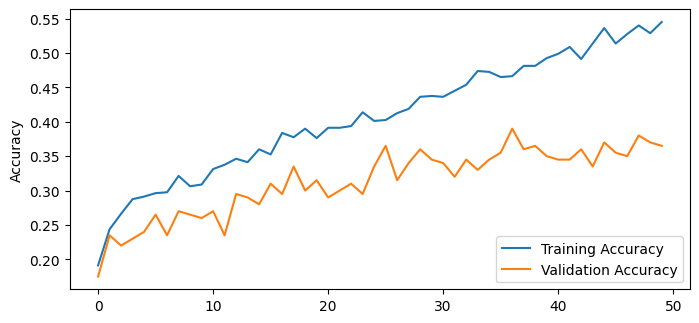

In [510]:
# evaluate model on test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))


# plot accuracy/error for training and validation
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

In [511]:
model_uri = "../modelh5/model_RNN.h5"
model.save(model_uri)

In [512]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_p = np.argmax(y_pred, axis=1)
y_t = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t, y_p)
cm

7/7 [==============================] - 1s 46ms/step


array([[16,  8,  4, 10, 10],
       [ 2, 15,  9,  5,  2],
       [ 9, 10,  8,  5,  6],
       [ 3,  8, 11, 17,  5],
       [ 2,  4,  7,  7, 17]])

In [513]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        48
           1       0.33      0.45      0.38        33
           2       0.21      0.21      0.21        38
           3       0.39      0.39      0.39        44
           4       0.42      0.46      0.44        37

    accuracy                           0.36       200
   macro avg       0.37      0.37      0.36       200
weighted avg       0.38      0.36      0.37       200



### Testing

In [514]:
new_model = tf.keras.models.load_model(model_uri)
new_model.summary()



Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_22 (SimpleRNN)   (None, 128)               16640     
                                                                 
 dense_70 (Dense)            (None, 128)               16512     
                                                                 
 dense_71 (Dense)            (None, 64)                8256      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dense_73 (Dense)            (None, 5)                 165       
                                                                 
Total params: 43,653
Trainable params: 43,653
Non-trainable params: 0
_________________________________________________________________


In [515]:
import wave
import json
header = 'filename'
for i in range(1, 41):
    header += f' mfcc{i}'
header += ' rms'
for i in range(1, 61):
  header += f' cqt{i}'
header += ' label'
header = header.split()


def extract_mfcc(audiofile):
    file = open('test.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    y, sr = librosa.load(audiofile, mono=True, duration=3, sr=8000)
    coeffs = wavedec(y, 'db1', level=10)
    cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
    mfcc = librosa.feature.mfcc(y=cD1, sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
    rms = librosa.feature.rms(y=cD1)[0]
    cqt = np.abs(librosa.cqt(y=cD1, sr=sr, n_bins=60)) 
    combined_features = np.concatenate((mfcc, rms.reshape(1, -1), cqt), axis=0)
    to_append = f'Signal'
    for e in combined_features:
        to_append += f' {np.mean(e.T, axis=0)}'
    file = open('test.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

def predict(audio):
    model = tf.keras.models.load_model(model_uri)
    extract_mfcc(audio)
    data = pd.read_csv('test.csv')
    df = data.drop(['label', 'filename'], axis=1)
    pred = model.predict(df)
    class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
    cek = np.argmax(pred[0])
    print(pred[0])
    print(cek)
    print(f'Predicted class: {class_labels[cek]}')

In [516]:
predict('../data/training/MVP/New_MVP_004.wav')

1/1 [==============================] - 0s 279ms/step
[0.1334217  0.15890329 0.11902063 0.2616295  0.32702494]
4
Predicted class: N
